In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math, os, glob
import seaborn as sns
import sys
from datetime import datetime, timedelta
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels
import pickle
%matplotlib inline

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [44]:
claims = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/Claims.csv')

In [45]:
claims.dtypes

MemberID                   int64
ProviderID               float64
Vendor                   float64
PCP                      float64
Year                      object
Specialty                 object
PlaceSvc                  object
PayDelay                  object
LengthOfStay              object
DSFS                      object
PrimaryConditionGroup     object
CharlsonIndex             object
ProcedureGroup            object
SupLOS                     int64
dtype: object

In [46]:
claims.head()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.000,172193.000,37796.000,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
1,97903248,3316066.000,726296.000,5300.000,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2,2759427,2997752.000,140343.000,91972.000,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
3,73570559,7053364.000,240043.000,70119.000,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
4,11837054,7557061.000,496247.000,68968.000,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [47]:
#Groupby theo giá trị của LengthOfStay
claims.groupby("LengthOfStay").count()
#tập data not null của LengthOfStay (dùng để phân tích). Thay đổi kiểu data hiện tại của LengthOfStay theo dạng ngày để có thể dễ cho các dự đoán nếu có

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
LengthOfStay,,,,,,,,,,,,,
1 day,56696,55550,55519,56275,56696,56531,56446,56696,52855,55916,56696,56481,56696
1- 2 weeks,1143,1053,1053,1083,1143,1134,1143,1143,1054,991,1143,1141,1143
2 days,6485,6406,6401,6423,6485,6445,6448,6485,5394,6072,6485,6441,6485
2- 4 weeks,961,893,893,932,961,955,961,961,901,908,961,945,961
26+ weeks,2,0,0,1,2,2,2,2,2,2,2,2,2
3 days,3246,3217,3214,3228,3246,3246,3236,3246,2789,2991,3246,3223,3246
4 days,1473,1447,1447,1454,1473,1473,1473,1473,1316,1311,1473,1470,1473
4- 8 weeks,903,877,877,891,903,903,902,903,830,846,903,899,903
5 days,510,496,496,502,510,510,509,510,464,422,510,507,510


In [48]:
#BIẾN ĐỔI CÁC BIẾN CATEGORICAL CÓ SỐ THÀNH INT
#LengthOfStay
def LOS_int(s):
    try:
        if 'day' in s:
            return int(s[0])
        if 'weeks' in s and s!= '26+ weeks':
            return int(s[3])*7
        else:
            return 26*7
    except:
        pass

In [49]:
claims['LengthOfStay']= claims['LengthOfStay'].apply(lambda x: LOS_int(x))
claims.groupby('LengthOfStay').count()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
LengthOfStay,,,,,,,,,,,,,
1.000,56696,55550,55519,56275,56696,56531,56446,56696,52855,55916,56696,56481,56696
2.000,6485,6406,6401,6423,6485,6445,6448,6485,5394,6072,6485,6441,6485
3.000,3246,3217,3214,3228,3246,3246,3236,3246,2789,2991,3246,3223,3246
4.000,1473,1447,1447,1454,1473,1473,1473,1473,1316,1311,1473,1470,1473
5.000,510,496,496,502,510,510,509,510,464,422,510,507,510
6.000,179,177,175,179,179,179,179,179,162,119,179,179,179
14.000,1143,1053,1053,1083,1143,1134,1143,1143,1054,991,1143,1141,1143
28.000,961,893,893,932,961,955,961,961,901,908,961,945,961
56.000,903,877,877,891,903,903,902,903,830,846,903,899,903


In [50]:
claims['PayDelay'].value_counts()

0       141451
162+     92592
28       87286
23       85165
29       83899
22       83380
24       82660
30       78784
21       78751
31       73889
35       70537
27       63693
36       60368
17       57018
16       56983
34       54340
37       54026
20       53773
38       48513
15       48435
42       43513
43       40619
44       36581
25       34889
45       32900
32       31582
41       30906
49       29986
50       29832
14       26861
51       26790
39       26245
52       24099
56       23747
18       23668
57       23600
58       21450
26       21126
46       20458
48       19957
59       19750
19       18399
63       18189
33       17294
64       17287
53       16683
65       15282
55       14345
66       14342
70       14300
71       14026
60       12822
40       12543
13       12542
72       12159
10       11883
11       11829
9        11612
77       11217
67       11077
73       11040
62       10685
8        10396
78       10296
12        9455
47        9431
79        

In [51]:
def PayDelay_int(s):
    try:
        if '+' in s:
            return int(s[:-1])
        if type(s) != int:
            return int(s)
    except:
        pass

In [52]:
claims['PayDelay']= claims['PayDelay'].apply(lambda x: PayDelay_int(x))
claims.groupby('PayDelay').count()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
PayDelay,,,,,,,,,,,,,
0,141451,140122,139541,140637,141451,140608,140575,5401,135859,140035,141451,141035,141451
1,94,94,94,94,94,94,94,0,94,93,94,94,94
2,269,269,269,269,269,269,269,0,266,269,269,269,269
3,3195,3195,3195,3195,3195,3195,3195,0,3179,3194,3195,3195,3195
4,4895,4893,4893,4894,4895,4892,4894,1,4857,4894,4895,4895,4895
5,5956,5952,5952,5955,5956,5954,5952,1,5899,5950,5956,5956,5956
6,1271,1271,1271,1271,1271,1271,1271,5,1261,1271,1271,1271,1271
7,4859,4855,4855,4856,4859,4857,4858,7,4823,4853,4859,4859,4859
8,10396,10385,10385,10391,10396,10388,10391,21,10313,10391,10396,10395,10396


['Year', 'Specialty', 'PlaceSvc', 'DSFS', 'PrimaryConditionGroup', 'CharlsonIndex', 'ProcedureGroup']


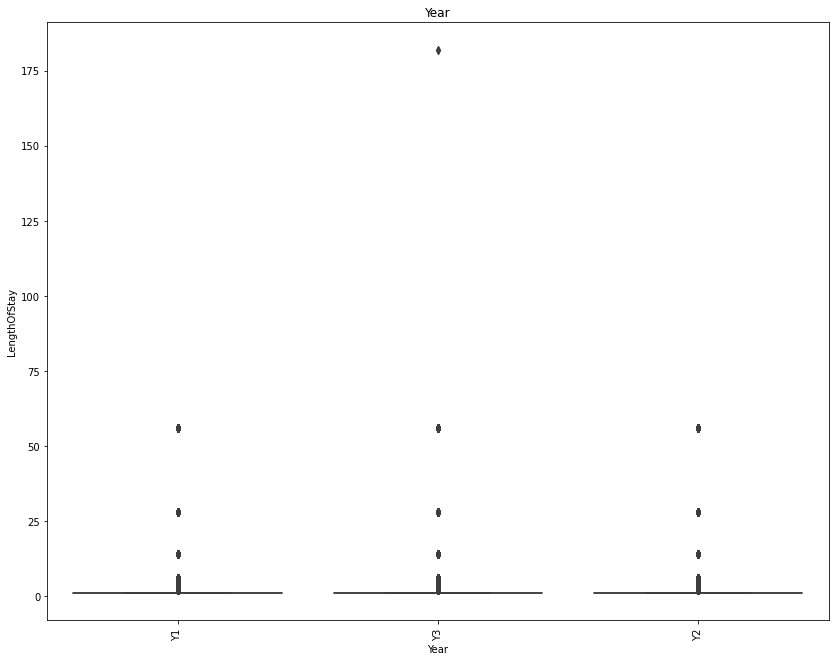

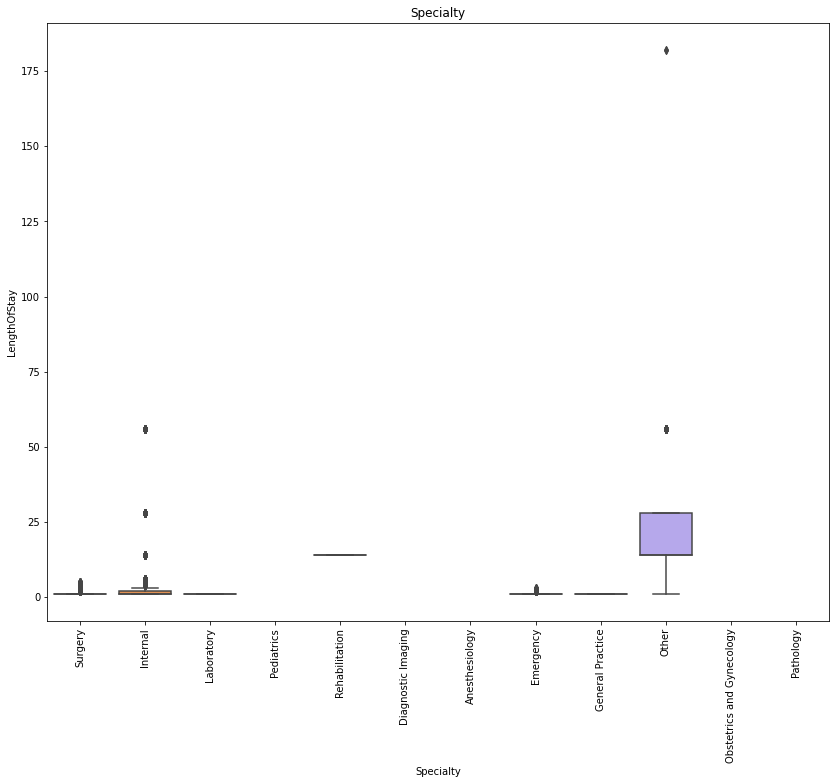

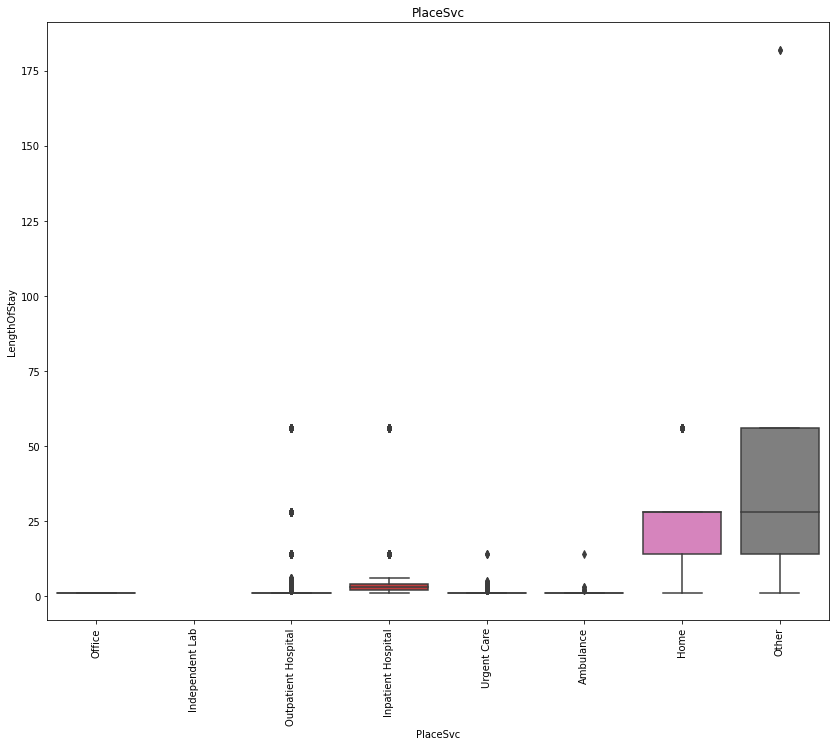

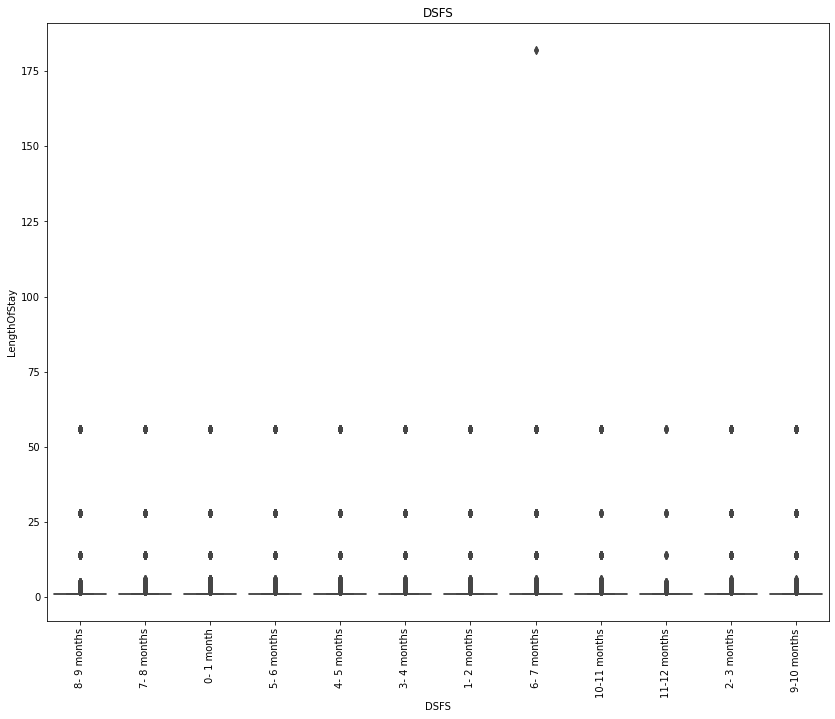

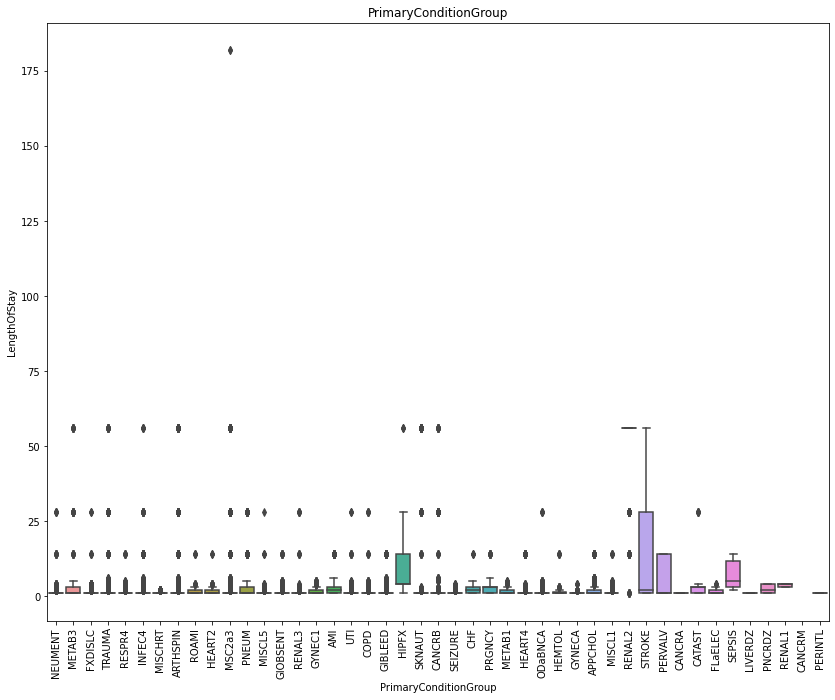

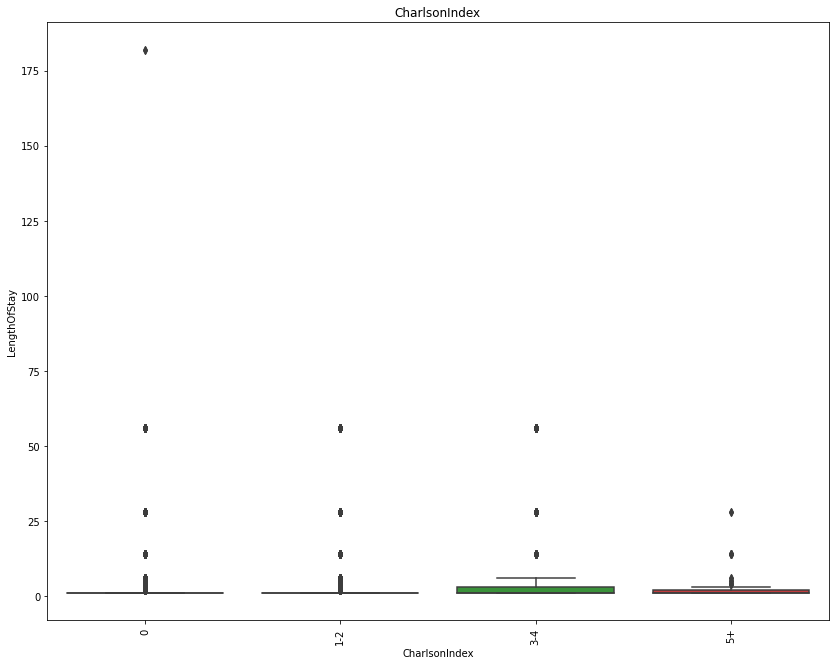

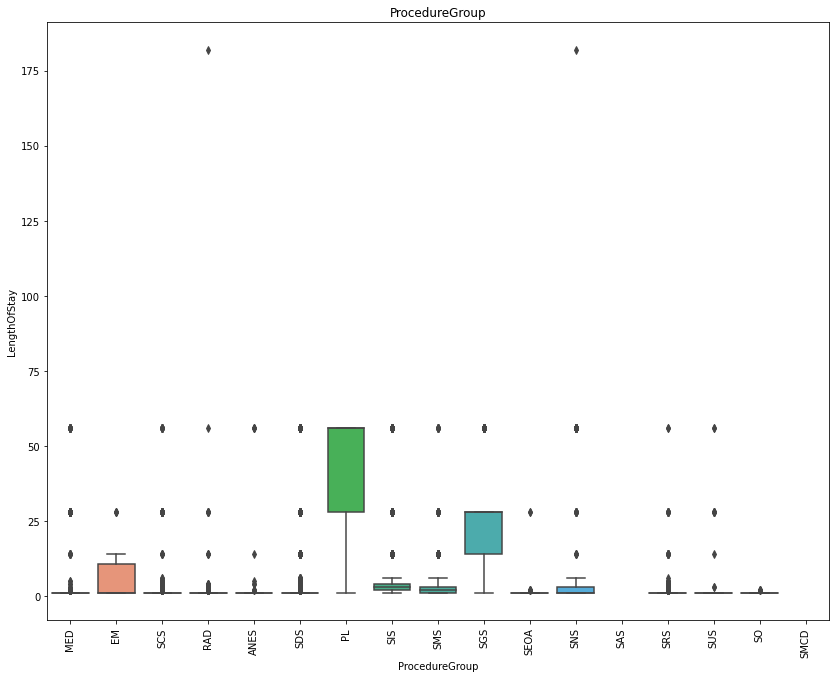

In [13]:
# Gọi tên các cột đang dạng categorical ra, và dựa vào bảng sample để quyết định biến đổi các cột như thế nào cho hợp lý
cate = ['object']
cate_columns = list(claims.select_dtypes(include = cate).columns)
print(cate_columns)

#Load hết tất cả các cột categorical chạy boxplot
for col in cate_columns2:
    plt.figure(figsize = (14, 11))
    sns.boxplot(x=col,y='LengthOfStay', data = claims)
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show

In [54]:
#Xem xét outlier của LengthOfStay
claims_out = claims[claims.LengthOfStay == 182]
claims_out
#Trường hợp này khá đặc biệt vì nằm ở Y3, không rõ các cột Year, Specialty, Provider, Vendor.
#Cùng 1 PCG
#Nên drop khỏi data để tránh bị outlier quá nhiều

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
499952,5843627,nan,nan,nan,Y3,Other,Other,0,182.000,6- 7 months,MSC2a3,0,RAD,0
2006640,5843627,nan,nan,36452.000,Y3,Other,Other,0,182.000,6- 7 months,MSC2a3,0,SNS,0
